In [332]:
"""Built after the CleanNeuralNetwork python file so to ensure no irreversible damage occurs"""

'Built after the CleanNeuralNetwork python file so to ensure no irreversible damage occurs'

In [365]:
import torch
#%matplotlib nbagg
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep

hep.style.use("CMS")


df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
signalname="GluGluToRadionToHHTo2G2Tau_M-290"
sig = df[df.process_id == proc_dict[f"{signalname}"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\2798741969.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [366]:
proc_dict

{'Data': 0,
 'DiPhoton': 3,
 'GluGluToRadionToHHTo2G2Tau_M-1000': -195,
 'GluGluToRadionToHHTo2G2Tau_M-250': -196,
 'GluGluToRadionToHHTo2G2Tau_M-260': -197,
 'GluGluToRadionToHHTo2G2Tau_M-270': -198,
 'GluGluToRadionToHHTo2G2Tau_M-280': -199,
 'GluGluToRadionToHHTo2G2Tau_M-290': -200,
 'GluGluToRadionToHHTo2G2Tau_M-300': -201,
 'GluGluToRadionToHHTo2G2Tau_M-320': -202,
 'GluGluToRadionToHHTo2G2Tau_M-350': -203,
 'GluGluToRadionToHHTo2G2Tau_M-400': -204,
 'GluGluToRadionToHHTo2G2Tau_M-450': -205,
 'GluGluToRadionToHHTo2G2Tau_M-500': -206,
 'GluGluToRadionToHHTo2G2Tau_M-550': -207,
 'GluGluToRadionToHHTo2G2Tau_M-600': -208,
 'GluGluToRadionToHHTo2G2Tau_M-650': -209,
 'GluGluToRadionToHHTo2G2Tau_M-700': -210,
 'GluGluToRadionToHHTo2G2Tau_M-750': -211,
 'GluGluToRadionToHHTo2G2Tau_M-800': -212,
 'GluGluToRadionToHHTo2G2Tau_M-900': -213,
 'TTGG': 7,
 'TTGamma': 6,
 'TTJets': 5,
 'VBFH_M125': 12,
 'VH_M125': 9,
 'WGamma': 4,
 'ZGamma': 2,
 'ggH_M125': 11,
 'ttH_M125': 10,
 'GJets': 8}

In [367]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [368]:
"""The features requiring exclusion of -9 values"""
MinusNineBinning=['ditau_met_dPhi',
                  'ditau_deta',
                  'ditau_dR',
                  'ditau_dphi',
                  'ditau_pt',
                  'Diphoton_ditau_dphi',
                  'dilep_leadpho_mass',
                  'reco_MX_mgg',
                  'Diphoton_ditau_deta',
                  'Diphoton_sublead_lepton_deta',
                  'Diphoton_sublead_lepton_dR',
                  'LeadPhoton_ditau_dR',
                  'ditau_mass']


In [369]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()

TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','ditau_met_dPhi','ditau_deta','Diphoton_sublead_lepton_deta','Diphoton_ditau_deta','ditau_mass','weight_central','Classification']
# includes classification and weights
#TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']
TopFeatures=['reco_MX_mgg','weight_central','Classification']

"""A dataset consisting of only the essential features"""
for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    
"""Removal of the values that are binned at -9 from the necessary features"""
for columns in df_TopFeatures.columns:
    if columns in MinusNineBinning:
        df_TopFeatures = df_TopFeatures.loc[(df_TopFeatures[columns] > -8)]


In [370]:
df_TopFeatures = df_TopFeatures.sample(frac=1, random_state=42)  # Setting frac=1 shuffles all rows

features = df_TopFeatures # Extracting features

labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()

weightofsignal=train_features[train_features['Classification']==1]['weight_central'].sum()
weightofbackground=train_features[train_features['Classification']==0]['weight_central'].sum()
scale=weightofsignal/weightofbackground

"""reweighting the weight_central column in entire data 
set such that for background and signal """
train_features.loc[train_features['Classification'] == 0, 'weight_central'] *= scale
test_features.loc[test_features['Classification'] == 0, 'weight_central'] *= scale


train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']



train_features = train_features.drop(columns=['weight_central'])
train_features = train_features.drop(columns=['Classification'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)



In [371]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN,self).__init__()
        self.hidden1 = nn.Linear(1, 8)
        self.act1 = nn.ReLU()
#         self.hidden2 = nn.Linear(20, 8)
#         self.act2 = nn.ReLU()
#         self.output = nn.Linear(8, 1)
#         self.hidden1 = nn.Linear(16, 8)
#         self.act1 = nn.ReLU()
#         self.hidden2 = nn.Linear(20, 40)
#         self.act2 = nn.ReLU()
#         self.hidden3 = nn.Linear(40, 16)
#         self.act3 = nn.ReLU()
#         self.hidden4 = nn.Linear(16, 8)
#         self.act4 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
      #  x = self.hidden2(x)
      #  x = self.act2(x)
      #  x = self.hidden3(x)
      #  x = self.act3(x)
      #  x = self.hidden4(x)
      #  x = self.act4(x)
        x = self.output(x)
        x = self.act_output(x)
        return x


    def weightedBCELoss(self, input, target, weight):
      x, y, w = input, target, weight
      log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
      #return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))
      return -w * (y*log(x) + (1-y)*log(1-x))
    
    def batch_weightedBCELoss(self, input, target, weight, batch_size):
#batch_weightedBCELoss(self, train, train_labels_tensor, train_weights_tensor, batch_size)
        self.batch_size=batch_size

        target=target.unsqueeze(1)
        
        
       # train=model.forward(input)

        total_batch_err=torch.empty(0,1)
        output_length=input.shape[0]
        batch_remainder=output_length%batch_size

        for i in range(0, output_length//batch_size):
            weights = weight[i*(batch_size):(i+1)*(batch_size), :]
            labels = target[i*(batch_size):(i+1)*(batch_size), :]
            inputs = input[i*(batch_size):(i+1)*(batch_size), :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            total_batch_err=torch.cat((total_batch_err,loss)) 
        #    print(total_batch_err.shape[0])

        if batch_remainder > 0:
            weights = weight[(output_length//batch_size)*batch_size:, :]
            labels = target[(output_length//batch_size)*batch_size:, :]
            inputs = input[(output_length//batch_size)*batch_size:, :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            #weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
            total_batch_err=torch.cat((total_batch_err,loss))
        #    print(total_batch_err.shape[0])
            
        return torch.mean(total_batch_err)


In [372]:
model = SimpleNN()
lr=0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
lossdata=[]
df_Prediction=pd.DataFrame()
epochs=200
epochlist=[]
for i in range(1,epochs+1):
    epochlist.append(i)
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    trained_data= pd.DataFrame(trained.detach().numpy())
    df_Prediction[f'Epoch {i}'] = trained_data
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
# figure=plt.figure()
# plt.plot(epochlist,lossdata)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()    

For Epoch 1: Loss = 0.00011961306881858036
For Epoch 2: Loss = 0.00011800544598372653
For Epoch 3: Loss = 0.00011648461077129468
For Epoch 4: Loss = 0.00011505446309456602
For Epoch 5: Loss = 0.00011371910659363493
For Epoch 6: Loss = 0.0001124826812883839
For Epoch 7: Loss = 0.0001113488688133657
For Epoch 8: Loss = 0.00011032138718292117
For Epoch 9: Loss = 0.00010940192441921681
For Epoch 10: Loss = 0.00010858976020244882
For Epoch 11: Loss = 0.00010788185318233445
For Epoch 12: Loss = 0.00010727396147558466
For Epoch 13: Loss = 0.00010676115198293701
For Epoch 14: Loss = 0.00010633793863235041
For Epoch 15: Loss = 0.00010599806410027668
For Epoch 16: Loss = 0.0001057346526067704
For Epoch 17: Loss = 0.0001055401298799552
For Epoch 18: Loss = 0.00010540625953581184
For Epoch 19: Loss = 0.00010532438318477944
For Epoch 20: Loss = 0.00010528556595090777
For Epoch 21: Loss = 0.0001052807638188824
For Epoch 22: Loss = 0.00010530112194828689
For Epoch 23: Loss = 0.000105338214780204
For 

C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 105: Loss = 0.00010435548756504431
For Epoch 106: Loss = 0.00010434861906105652
For Epoch 107: Loss = 0.00010434189607622102
For Epoch 108: Loss = 0.00010433529678266495
For Epoch 109: Loss = 0.00010432882118038833


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 110: Loss = 0.0001043224983732216
For Epoch 111: Loss = 0.0001043162847054191
For Epoch 112: Loss = 0.00010431018745293841
For Epoch 113: Loss = 0.00010430420661577955
For Epoch 114: Loss = 0.00010429832764202729


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 115: Loss = 0.00010429257963551208
For Epoch 116: Loss = 0.0001042868971126154
For Epoch 117: Loss = 0.0001042813019012101
For Epoch 118: Loss = 0.000104275815829169
For Epoch 119: Loss = 0.00010427039524074644


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 120: Loss = 0.00010426506196381524
For Epoch 121: Loss = 0.00010425981599837542
For Epoch 122: Loss = 0.00010425465006846935
For Epoch 123: Loss = 0.00010424956417409703
For Epoch 124: Loss = 0.00010424455103930086


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 125: Loss = 0.00010423962521599606
For Epoch 126: Loss = 0.00010423480853205547
For Epoch 127: Loss = 0.00010423007188364863
For Epoch 128: Loss = 0.00010422542254673317
For Epoch 129: Loss = 0.00010422082414152101


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 130: Loss = 0.00010421626211609691
For Epoch 131: Loss = 0.0001042117946781218
For Epoch 132: Loss = 0.00010420737089589238
For Epoch 133: Loss = 0.00010420299804536626
For Epoch 134: Loss = 0.00010419871978228912
For Epoch 135: Loss = 0.00010419453610666096
For Epoch 136: Loss = 0.00010419033060315996
For Epoch 137: Loss = 0.00010418610327178612
For Epoch 138: Loss = 0.0001041818832163699


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 139: Loss = 0.00010417765588499606
For Epoch 140: Loss = 0.00010417344310553744
For Epoch 141: Loss = 0.00010416924487799406
For Epoch 142: Loss = 0.00010416504665045068
For Epoch 143: Loss = 0.00010416086297482252


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 144: Loss = 0.00010415665747132152
For Epoch 145: Loss = 0.0001041524374159053
For Epoch 146: Loss = 0.00010414817370474339
For Epoch 147: Loss = 0.00010414385178592056
For Epoch 148: Loss = 0.00010413952986709774


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 149: Loss = 0.00010413505515316501
For Epoch 150: Loss = 0.00010413050767965615
For Epoch 151: Loss = 0.00010412579285912216
For Epoch 152: Loss = 0.00010412080155219883
For Epoch 153: Loss = 0.00010411563562229276


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 154: Loss = 0.00010411033872514963
For Epoch 155: Loss = 0.00010410500544821844
For Epoch 156: Loss = 0.00010409961396362633
For Epoch 157: Loss = 0.00010409409151179716
For Epoch 158: Loss = 0.00010408845264464617


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 159: Loss = 0.0001040824135998264
For Epoch 160: Loss = 0.00010407563240732998
For Epoch 161: Loss = 0.00010406832734588534
For Epoch 162: Loss = 0.00010406053479528055
For Epoch 163: Loss = 0.00010405218927189708


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 164: Loss = 0.00010404303611721843
For Epoch 165: Loss = 0.00010403331543784589
For Epoch 166: Loss = 0.00010402268526377156
For Epoch 167: Loss = 0.00010401004692539573
For Epoch 168: Loss = 0.00010399634629720822
For Epoch 169: Loss = 0.00010398128506494686
For Epoch 170: Loss = 0.00010396497964393348
For Epoch 171: Loss = 0.00010394684795755893
For Epoch 172: Loss = 0.00010392721742391586


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 173: Loss = 0.00010390547686256468
For Epoch 174: Loss = 0.00010388062219135463
For Epoch 175: Loss = 0.00010385081986896694
For Epoch 176: Loss = 0.00010381284664617851
For Epoch 177: Loss = 0.00010376785940025002


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 178: Loss = 0.00010370930249337107
For Epoch 179: Loss = 0.0001036396570270881
For Epoch 180: Loss = 0.00010355789709137753
For Epoch 181: Loss = 0.00010346566705266014
For Epoch 182: Loss = 0.00010336450213799253
For Epoch 183: Loss = 0.00010325327457394451


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 184: Loss = 0.00010313104576198384
For Epoch 185: Loss = 0.00010298978304490447
For Epoch 186: Loss = 0.0001028241022140719
For Epoch 187: Loss = 0.0001026530735543929
For Epoch 188: Loss = 0.00010248439502902329
For Epoch 189: Loss = 0.00010232169734081253


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 190: Loss = 0.00010217119415756315
For Epoch 191: Loss = 0.00010203715646639466
For Epoch 192: Loss = 0.00010192260378971696
For Epoch 193: Loss = 0.0001018237744574435
For Epoch 194: Loss = 0.00010173775081057101
For Epoch 195: Loss = 0.00010165442654397339


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

For Epoch 196: Loss = 0.00010156573262065649
For Epoch 197: Loss = 0.00010146993736270815
For Epoch 198: Loss = 0.0001013701839838177
For Epoch 199: Loss = 0.00010127190034836531
For Epoch 200: Loss = 0.00010118125646840781


C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Prediction[f'Epoch {i}'] = trained_data
C:\Users\drpla\AppData\Local\Temp\ipykernel_8504\158212270.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

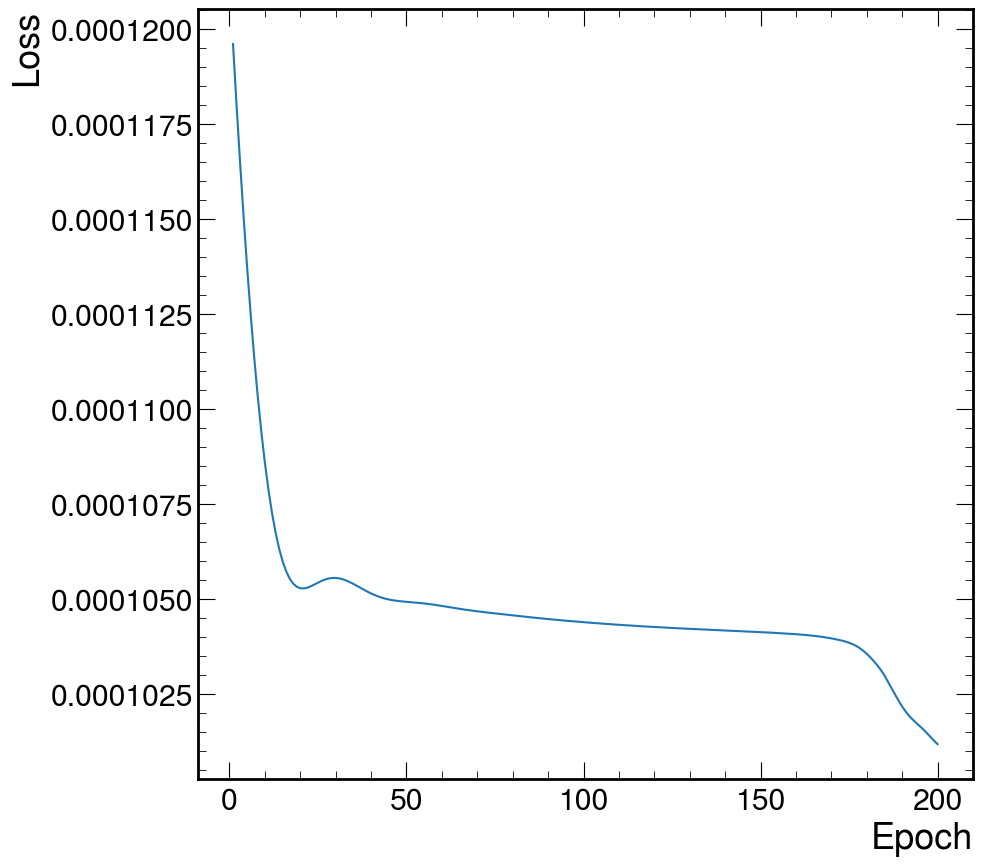

In [373]:
"""
Plot of Loss vs Epoch
"""

figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

In [374]:
"""Adding the labels to the prediction dataframe"""
#epoch_= 'Epoch 99'
epoch_=f'Epoch {epochs-1}'
train_labels_=pd.DataFrame({'Classification': train_labels}).reset_index(drop=True)
df_Prediction = pd.concat([df_Prediction, train_labels_], axis=1)

In [375]:
# #epoch_= 'Epoch 99'
# epoch_=f'Epoch {epochs-1}'
# plt.figure()
# plt.hist(df_Prediction[epoch_],bins=80,label='trained',histtype="step",color='orange')
# plt.hist(train_labels,bins=80,histtype='step',color='grey',label='expected')
# plt.legend()
# plt.xlabel('Classification of Events')
# plt.ylabel('Number of Events')
# plt.title('Comparison of the expected output and the trained output')
# #plt.savefig(f"BenNeuralNetworkPlots/TrainingHist-{signalname}Epochs={epochs}")
# plt.show()

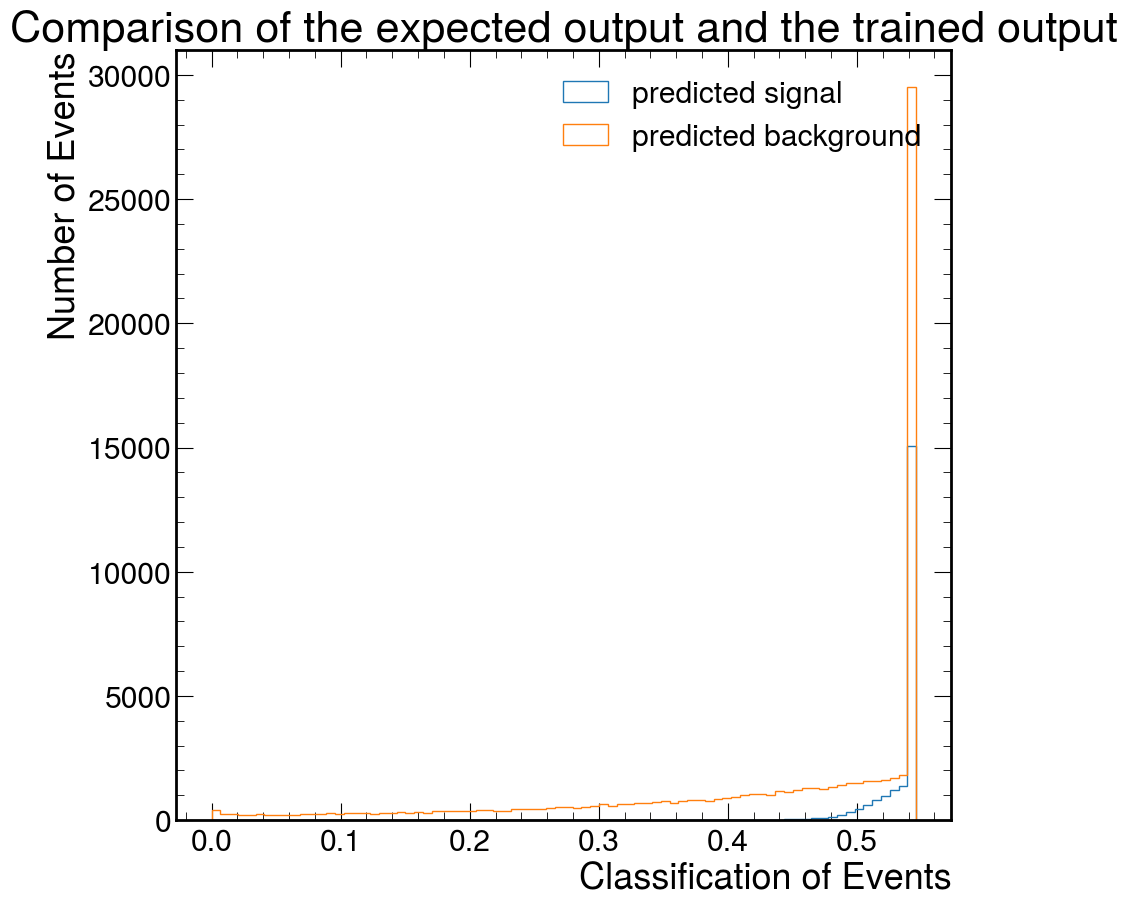

In [376]:
#epoch_= 'Epoch 99'
epoch_=f'Epoch {epochs-1}'
plt.figure()
plt.hist(df_Prediction[df_Prediction['Classification']==1][epoch_],bins=80,label='predicted signal',histtype="step")
plt.hist(df_Prediction[df_Prediction['Classification']==0][epoch_],bins=80,histtype='step',label='predicted background')
plt.legend()
plt.xlabel('Classification of Events')
plt.ylabel('Number of Events')
plt.title('Comparison of the expected output and the trained output')
#plt.savefig(f"BenNeuralNetworkPlots/TrainingHist-{signalname}Epochs={epochs}")
plt.show()

In [377]:

df_Prediction.sort_values(by=[epoch_,'Classification'], ascending=True)
import scipy as scipy

#%%
direction='above' #use this to determine the side of the threshold that calculates TPR and FPR

threshold_direction = f'Signal is {direction} Background'


minimum_edge=0
maximum_edge=1
steps=1000
stepsize=(maximum_edge-minimum_edge)/steps

threshold=minimum_edge
TPR_arr = []
FPR_arr = []
for i in range(0,steps): 
    if threshold_direction == 'Signal is above Background':
        threshold += stepsize
       
        TP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==1)][epoch_])#
        FP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==0)][epoch_])#
        FN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==1)][epoch_])#
        TN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==0)][epoch_])#
        print('run',i)
                
        if (TP+FN) == 0:
            TPR = 0
            FPR = 0
        else:
            TPR = TP/(TP +FN)
            FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        
    elif threshold_direction == 'Signal is below Background':
        threshold += stepsize
       
     #   TP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==1)][epoch_])#
      #  FP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==0)][epoch_])#
       # FN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==1)][epoch_])#
        #TN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==0)][epoch_])#
        
        print('run',i)
        
        TPR = TP/(TP +FN)
        FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        


sorted_values = sorted(zip(FPR_arr, TPR_arr))
FPR_arr, TPR_arr = zip(*sorted_values)


run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

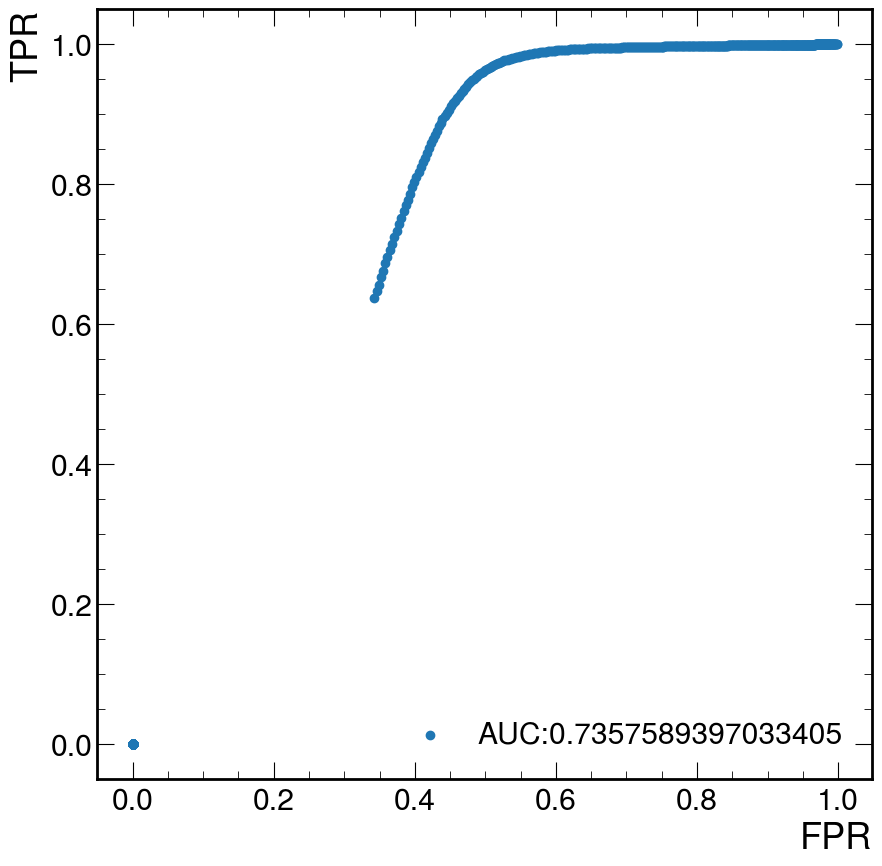

0.7357589397033405


In [378]:
AUCscore=scipy.integrate.trapezoid(TPR_arr,FPR_arr,  dx=stepsize,axis=-1)
fig=plt.figure()    
plt.scatter(FPR_arr,TPR_arr,label=f'AUC:{AUCscore}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()
print(AUCscore)

In [379]:
# df_Prediction = df_Prediction.drop(columns='Classification')

BenNeuralNetworkPlots/reco_MX_mgg_SimArch/HIST_LOSS_ROC_GluGluToRadionToHHTo2G2Tau_M-290=_Feature=reco_MX_mgg_Epochs=200


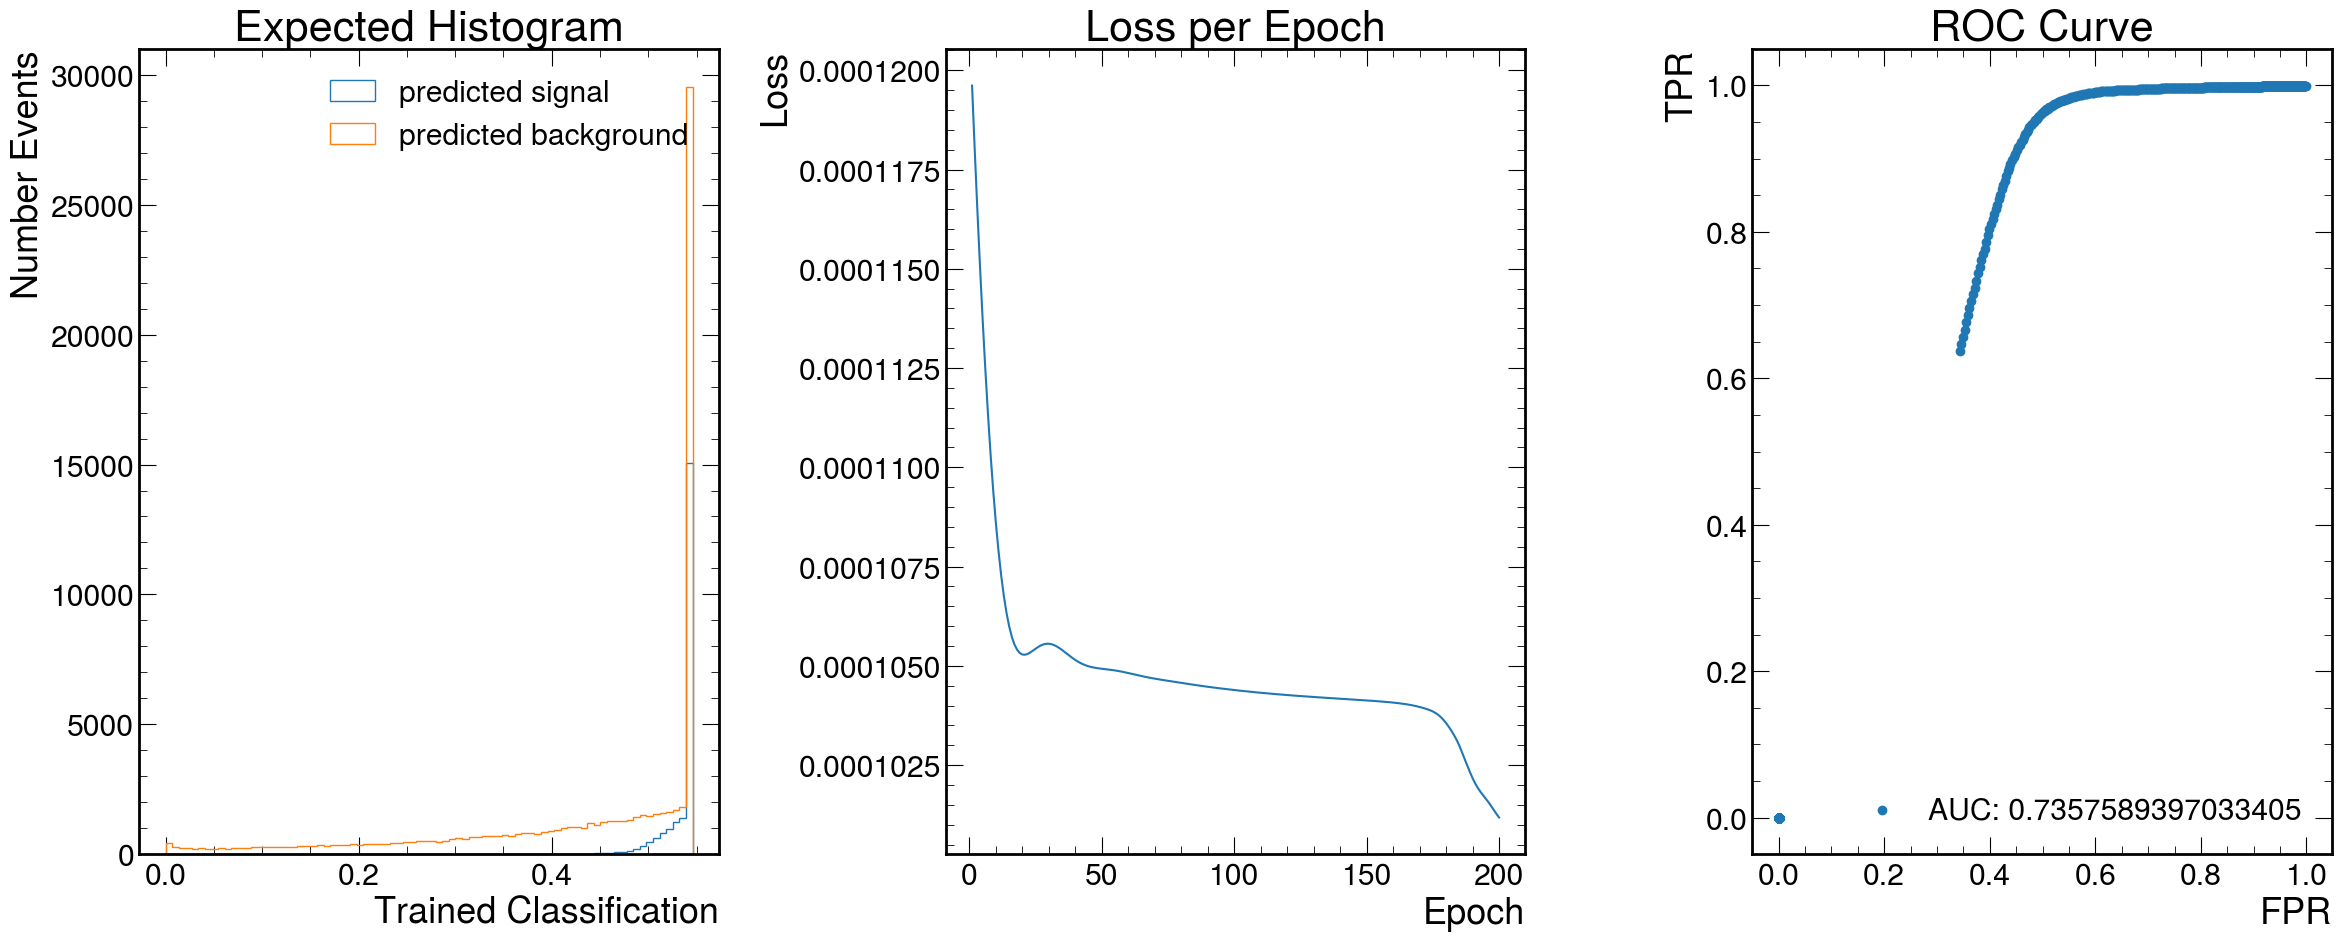

In [380]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10))

# Plot 1: Line plot (plt.plot)
axs[1].plot(epochlist, lossdata)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss per Epoch')

# Plot 2: Histograms (two separate subplots)

axs[0].set_title('Trained Histogram')

axs[0].set_xlabel('Trained Classification')
axs[0].set_ylabel('Number Events')

axs[0].hist(df_Prediction[df_Prediction['Classification']==1][epoch_],bins=80,label='predicted signal',histtype="step")
axs[0].hist(df_Prediction[df_Prediction['Classification']==0][epoch_],bins=80,histtype='step',label='predicted background')
axs[0].legend()
axs[0].set_title('Expected Histogram')

# Plot 3: Scatter plot with AUC score
axs[2].scatter(FPR_arr, TPR_arr, label=f'AUC: {AUCscore}')
axs[2].set_xlabel('FPR')
axs[2].set_ylabel('TPR')
axs[2].legend()
axs[2].set_title('ROC Curve')

# Adjust layout and display
plt.tight_layout()
plt.savefig(f"BenNeuralNetworkPlots/reco_MX_mgg_SimArch/HIST_LOSS_ROC_{signalname}=_Feature={TopFeatures[0]}_Epochs={epochs}")
print(f"BenNeuralNetworkPlots/reco_MX_mgg_SimArch/HIST_LOSS_ROC_{signalname}=_Feature={TopFeatures[0]}_Epochs={epochs}")

plt.show()


In [310]:
epochs

200

In [311]:
TopFeatures

['reco_MX_mgg', 'weight_central', 'Classification']

In [312]:
epoch_

'Epoch 199'

In [257]:
print(df_Prediction[epoch_].shape,train_labels.shape)

(120084,) (120084,)


In [124]:
df_Prediction


,Epoch 0,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,...,Epoch 190,Epoch 191,Epoch 192,Epoch 193,Epoch 194,Epoch 195,Epoch 196,Epoch 197,Epoch 198,Epoch 199
0,0.444147,0.458233,0.472196,0.485939,0.499333,0.512207,0.524348,0.535531,0.545590,0.554009,...,0.460362,0.460788,0.461212,0.461634,0.462054,0.462470,0.462882,0.463289,0.463691,0.464087
1,0.446698,0.460499,0.474174,0.487628,0.500734,0.513323,0.525183,0.536031,0.545227,0.553378,...,0.415350,0.415642,0.415934,0.416225,0.416515,0.416803,0.417088,0.417369,0.417647,0.417920
2,0.483479,0.490808,0.498146,0.505426,0.512548,0.519368,0.525695,0.531321,0.536085,0.539947,...,0.019453,0.019281,0.019113,0.018948,0.018786,0.018628,0.018472,0.018320,0.018170,0.018023
3,0.481731,0.489296,0.496872,0.504392,0.511755,0.518816,0.525383,0.531247,0.536248,0.540342,...,0.021053,0.020873,0.020697,0.020524,0.020354,0.020187,0.020024,0.019864,0.019706,0.019552
4,0.482032,0.489556,0.497091,0.504569,0.511891,0.518910,0.525437,0.531259,0.536220,0.540274,...,0.020769,0.020591,0.020416,0.020244,0.020076,0.019911,0.019749,0.019590,0.019434,0.019280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658328,0.380351,0.403399,0.426794,0.450346,0.473827,0.496961,0.519436,0.540934,0.561213,0.580176,...,0.985755,0.985900,0.986041,0.986179,0.986315,0.986448,0.986579,0.986706,0.986831,0.986954
658329,0.483029,0.490419,0.497818,0.505160,0.512344,0.519226,0.525615,0.531302,0.536127,0.540048,...,0.019853,0.019679,0.019509,0.019342,0.019178,0.019018,0.018860,0.018705,0.018554,0.018405
658330,0.379723,0.402868,0.426366,0.450026,0.473617,0.496865,0.519451,0.541059,0.561445,0.580511,...,0.986319,0.986459,0.986596,0.986730,0.986862,0.986990,0.987117,0.987240,0.987362,0.987480
658331,0.480494,0.488226,0.495970,0.503660,0.511193,0.518425,0.525162,0.531194,0.536362,0.540622,...,0.022263,0.022077,0.021894,0.021715,0.021540,0.021368,0.021199,0.021033,0.020870,0.020710


(array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [4.04800e+03, 1.04160e+04, 1.33100e+04, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [1.12000e+03, 1.12700e+03, 1.23200e+03, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        ...,
        [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 3.10000e+01, 6.60000e+01, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [1.22759e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]),
 array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
         1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
         2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
         3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
         4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
         5.  

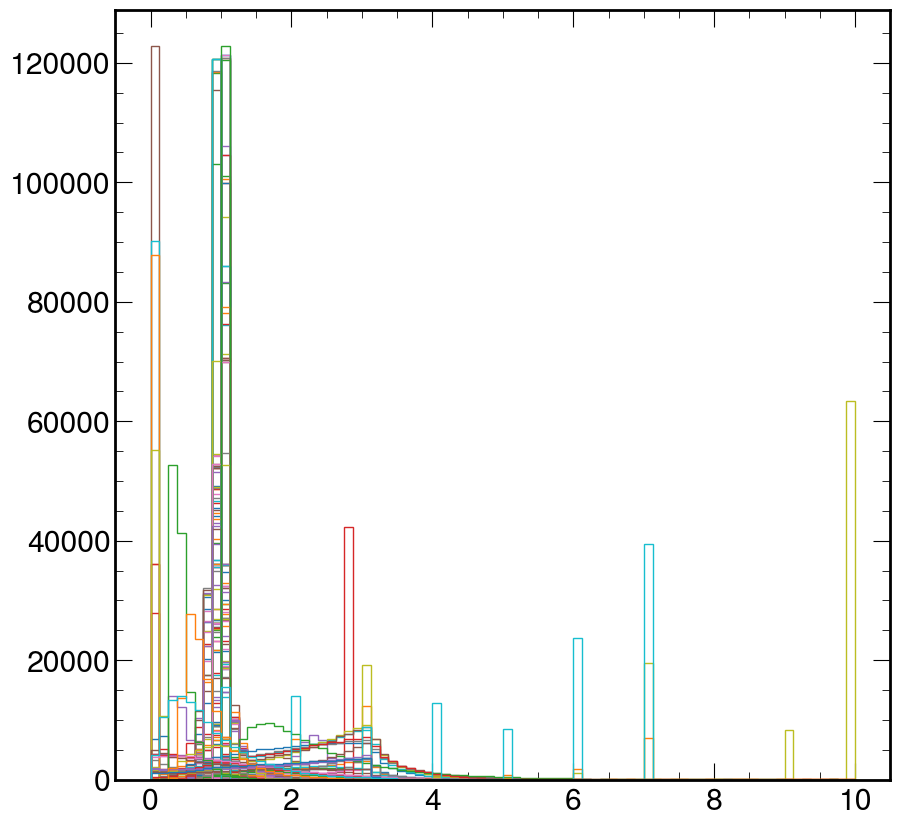

In [331]:
plt.hist(sig[sig['reco_MX_mgg']>-5],bins=80,histtype='step',range=(0,10))
plt.hist(background[background['reco_MX_mgg']>-5],bins=80,histtype='step',range=(0,10))